## Introduction to Natural Language Processing tasks  
#### Text Classification

In [0]:
!pip install -U eli5

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_20newsgroups

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

import eli5

"Traditional" Text Classification with Scikit-learn
In this notebook, we're going to experiment with a few "traditional" approaches to text classification. These approaches pre-date the deep learning revolution in Natural Language Processing, but are often quick and effective ways of training a text classifier.

Data
For our data, we're going to work with the 20 Newsgroups data set, a classic collection of text documents that is often used as a benchmark for text classification models. The set contains texts about various topics, ranging from computer hardward to religion. Some of the topics are closely related to each other (such as "IBM PC hardware" and "Mac hardware"), while others are very different (such as "religion" or "hockey"). The 20 Newsgroups comes shipped with the Scikit-learn machine learning library, our main tool for this exercise. It has been split into training set of 11,314 texts and a test set of 7,532 texts.

In [0]:
train_data = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
test_data = fetch_20newsgroups(subset='test')

print("Training texts:", len(train_data.data))
print("Test texts:", len(test_data.data))

Training texts: 11314
Test texts: 7532

#### Preprocessing  

The first step in the development of any NLP model is text preprocessing. This means we're going to transform our texts from word sequences to feature vectors. These feature vectors contain their values for each of a large number of features.  

In this experiment, we're going to work with so-called "bag-of-word" approaches. Bag-of-word methods treat every text as an unordered collection of words (or optionally, ngrams), and the raw feature vectors simply tell us how often each word (or ngram) occurs in a text. In Scikit-learn, we can construct these raw feature vectors with the CountVectorizer, which tokenizes a text and counts the number of times any given text contains every token in the corpus.  

However, these raw counts are not very informative yet. This is because the raw feature vectors of most texts in the same language will be very similar. For example, most texts in English contain many instances of relatively uninformative words, such as a, the or be. Instead, what we're interested in are words like computer or hardware: words that occur often in one text, but not very often in the corpus as a whole. Therefore we're going to weight all features by their tf-idf score, which counts the number of times every token appears in a text and divides it by (the logarithm of) the percentage of corpus documents that contain that token. This weighting is performed by Scikit-learn's TfidfTransformer.  

To obtain the weighted feature vectors, we combine the CountVectorizer and TfidfTransformer in a Pipeline, and fit this pipeline on the training data. We then transform both the training texts and the test texts to a collection of such weighted feature vectors. Scikit-learn also has a TfidfVectorizer, which achieves the same result as our pipeline.

In [0]:
preprocessing = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer())
])
  
print("Preprocessing training data...")
train_preprocessed = preprocessing.fit_transform(train_data.data)

print("Preprocessing test data...")
test_preprocessed = preprocessing.transform(test_data.data)

Preprocessing training data...
Preprocessing test data...

#### Training

Next, we train a text classifier on the preprocessed training data. We're going to experiment with three classic text classification models: Naive Bayes, Support Vector Machines and Logistic Regression. 

[Naive Bayes classifiers](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) are extremely simple classifiers that assume all features are independent of each other. They just learn how frequent all classes are and how frequently each feature occurs in a class. To classify a new text, they simply multiply the probabilities for every feature $x_i$ given each class $C$ and pick the class that gives the highest probability: 

\begin{equation*}
\hat y = argmax_k\  p(C_k) \prod_{i=1}^n p(x_i \mid C_k)
\end{equation*}

Naive Bayes Classifiers are very quick to train, but usually fall behind in terms of performance.

[Support Vector Machines](https://en.wikipedia.org/wiki/Support_vector_machine) are much more advanced than Naive Bayes classifiers. They try to find the hyperplane in the feature space that best separates the data from the different classes. They do so by picking the hyperplane that maximizes the distance to the nearest data point on each side. When the classes are not linearly separable, SVMs map the data into a higher-dimensional space where a linear separation can hopefully be found. SVMs often achieve very good performance in text classification tasks.

[Logistic Regression models](https://en.wikipedia.org/wiki/Logistic_regression), finally, model the log-odds $l$, or $log(p/(1-p))$, of a class as a linear model and estimate the parameters $\beta$ of the model during training: 

\begin{equation*}
l = \beta_0 + \sum_{i=1}^n \beta_i x_i
\end{equation*}

Like SVMs, they often achieve great performance in text classification.

##### Simple training
We train our three classifiers in Scikit-learn with the fit method, giving it the preprocessed training text and the correct classes for each text as parameters.

In [0]:
nb_classifier = MultinomialNB()
svm_classifier = LinearSVC()
lr_classifier = LogisticRegression(multi_class="ovr")

print("Training Naive Bayes classifier...")
nb_classifier.fit(train_preprocessed, train_data.target)

print("Training SVM classifier...")
svm_classifier.fit(train_preprocessed, train_data.target)

print("Training Logistic Regression classifier...")
lr_classifier.fit(train_preprocessed, train_data.target)

Training Naive Bayes classifier...
Training SVM classifier...
Training Logistic Regression classifier...
Out[4]: LogisticRegression(multi_class='ovr')

Let's find out how well each classifier performs. To find oud, we have each classifier `predict` the label for all texts in our preprocessed test set.

In [0]:
nb_predictions = nb_classifier.predict(test_preprocessed)
svm_predictions = svm_classifier.predict(test_preprocessed)
lr_predictions = lr_classifier.predict(test_preprocessed)

Now we can compute the accuracy of each model: the proportion of test texts for which the predicted label is the same as the target label. The Naive Bayes classifier assigned the correct label in 77.4% of the cases, the logistic regression model achieves an accuracy of 82.8%, and the Support Vector Machine got the label right 85.3% of the time.

In [0]:
print("NB Accuracy:", np.mean(nb_predictions == test_data.target))
print("SVM Accuracy:", np.mean(svm_predictions == test_data.target))
print("LR Accuracy:", np.mean(lr_predictions == test_data.target))

NB Accuracy: 0.7738980350504514
SVM Accuracy: 0.8531598513011153
LR Accuracy: 0.8278013807753585

#### Grid search

Still, it's a bit too early to announce the winner. It's very likely we haven't yet got the most from our classifiers. When we trained them above, we just used the default values for most hyperparameters. However, these hyperparameter values can have a big impact on accuracy. Therefore we want to explore the parameter space a bit more extensively, and find out what hyperparameter values give the best results. We do this with so-called grid search. In grid search, we define a grid of hyperparameter values that we want to explore. Scikit-learn then steps to this grid to find the best combination. It does this with $n$-fold cross-validation: for each parameter combination in the grid, it fits a predefined number of models ($n$, the `cv` parameter in `GridSearchCV`. It splits up the training data in $n$ folds, fits a model on all but one of these folds, and tests it on the held-out fold. When it has done this $n$ times, it computes the average performance, and moves on. It performs the full hyperparameter grid in this way and keeps the model with the best average performance over the folds.

In this example, we'll experiment with the $C$ hyperparameter. $C$ controls the degree of regularization in support vector machines and logistic regression. Regularization combats overfitting by imposing a penalty on large parameter values in the model. The lower the $C$ value, the more regularization is applied.

In [0]:
parameters = {'C': np.logspace(0, 3, 10)}
parameters = {'C': [0.1, 1, 10, 100, 1000]}

print("Grid search for SVM")
svm_best = GridSearchCV(svm_classifier, parameters, cv=3, verbose=1, n_jobs=-1)
svm_best.fit(train_preprocessed, train_data.target)

print("Grid search for logistic regression")
lr_best = GridSearchCV(lr_classifier, parameters, cv=3, verbose=1, n_jobs=-1)
lr_best.fit(train_preprocessed, train_data.target)

Grid search for SVM
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 15 out of 15 | elapsed: 1.5min finished
Grid search for logistic regression
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 15 out of 15 | elapsed: 6.9min finished
/databricks/python/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
 https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 n_iter_i = _check_optimize_result(
/databricks/python/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
 https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 n_iter_i = _check_optimize_result(
/databricks/python/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
 https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 n_iter_i = _check_optimize_result(
/databricks/python/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
 https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 n_iter_i = _check_optimize_result(
/databricks/python/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
 https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 n_iter_i = _check_optimize_result(
/databricks/python/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
 https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 n_iter_i = _check_optimize_result(
/databricks/python/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
 https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

When grid search has been completed, we can find out what hyperparameter values led to the best-performing model.

In [0]:
print("Best SVM Parameters")
print(svm_best.best_params_)

print("Best LR parameters:")
print(lr_best.best_params_)

Best SVM Parameters
{'C': 1}
Best LR parameters:
{'C': 1000}

Let's see if these best models now perform any better on our test data. For the SVM, the default setting seems to have worked best: our other values didn't lead to a higher accuracy. For logistic regression, however, the default  𝐶  value was clearly not the most optimal one. When we increase  𝐶  to  1000 , the logistic regression model performs almost as well as the SVM.

In [0]:
best_svm_predictions = svm_best.predict(test_preprocessed)
best_lr_predictions = lr_best.predict(test_preprocessed)

print("Best SVM Accuracy:", np.mean(best_svm_predictions == test_data.target))
print("Best LR Accuracy:", np.mean(best_lr_predictions == test_data.target))

Best SVM Accuracy: 0.8531598513011153
Best LR Accuracy: 0.8514338821030271

### Extensive evaluation

#### Detailed scores

So far we've only looked at the accuracy of our models: the proportion of test examples for which their prediction is correct. This is fine as a first evaluation, but it doesn't give us much insight in what mistakes the models make and why. We'll therefore perform a much more extensive evaluation, in three steps. Let's start by computing the precision, recall and F-score of the best SVM for the individual classes:

- Precision is the number of times the classifier predicted a class correctly, divided by the total number of times it predicted this class. 
- Recall is the proportion of documents with a given class that were labelled correctly by the classifier. 
- The F1-score is the harmonic mean between precision and recall: $2*P*R/(P+R)$

The classification report below shows, for example, that the sports classes were quite easy to predict, while the computer and some of the politics classes proved much more difficult.

In [0]:
print(classification_report(test_data.target, best_svm_predictions, target_names=test_data.target_names))

precision recall f1-score support

 alt.atheism 0.82 0.80 0.81 319
 comp.graphics 0.76 0.80 0.78 389
 comp.os.ms-windows.misc 0.77 0.73 0.75 394
comp.sys.ibm.pc.hardware 0.71 0.76 0.74 392
 comp.sys.mac.hardware 0.84 0.86 0.85 385
 comp.windows.x 0.87 0.76 0.81 395
 misc.forsale 0.83 0.91 0.87 390
 rec.autos 0.92 0.91 0.91 396
 rec.motorcycles 0.95 0.95 0.95 398
 rec.sport.baseball 0.92 0.95 0.93 397
 rec.sport.hockey 0.96 0.98 0.97 399
 sci.crypt 0.93 0.94 0.93 396
 sci.electronics 0.81 0.79 0.80 393
 sci.med 0.90 0.87 0.88 396
 sci.space 0.90 0.93 0.92 394
 soc.religion.christian 0.84 0.93 0.88 398
 talk.politics.guns 0.75 0.92 0.82 364
 talk.politics.mideast 0.97 0.89 0.93 376
 talk.politics.misc 0.82 0.62 0.71 310
 talk.religion.misc 0.75 0.61 0.68 251

 accuracy 0.85 7532
 macro avg 0.85 0.85 0.85 7532
 weighted avg 0.85 0.85 0.85 7532

#### Confusion matrix  

Second, we're going to visualize our results in even more detail, using a so-called confusion matrix. A confusion matrix helps us better understand the errors our classifier makes. Its rows display the actual labels, its columns show the predictions of our classifier. This means all correct predictions will lie on the diagonal, where the actual label and the predicted label are the same. The predictions elsewhere in the matrix help us understand what classes are often mixed up by our classifier. Our confusion matrix shows, for example, that 91 documents with the label talk.politics.misc incorrectly received the label talk.politics.guns. Similarly, our classifier sometimes fails to tell apart the two religion classes, and gets quite mixed up in the computer topics in the top left corner.

Out[21]:

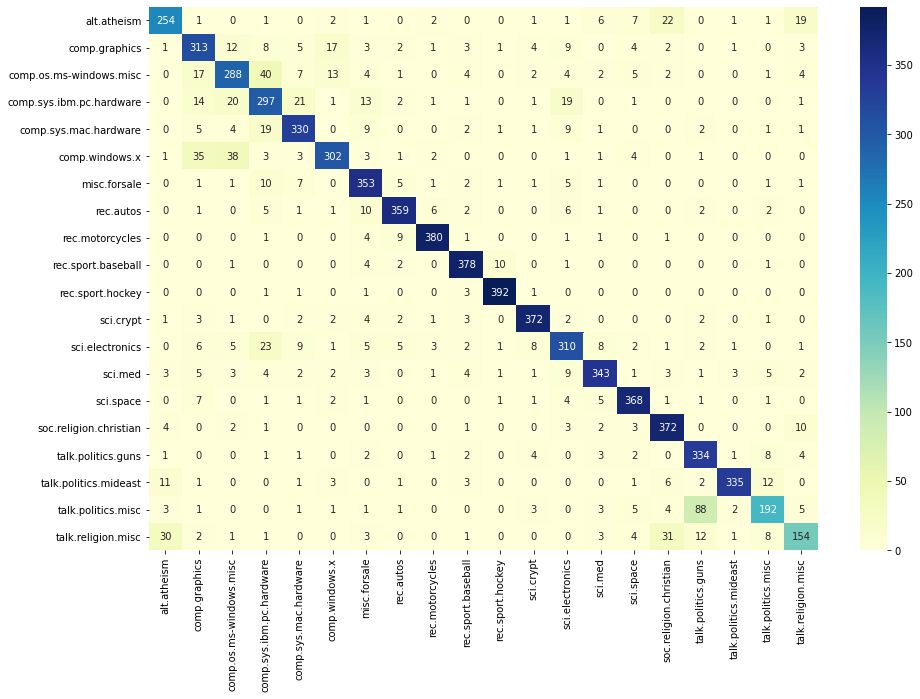

(array([ 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5,
 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 <a list of 20 Text major ticklabel objects>)

In [0]:
conf_matrix = confusion_matrix(test_data.target, best_svm_predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, index=test_data.target_names, columns=test_data.target_names)

plt.figure(figsize=(15, 10))
sn.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)

#### Explainability

Finally, we'd like to perform a more qualitative evaluation of our model by taking a look at the features that it assigns the highest weight for each of the classes. This will help us understand if the model indeed captures the phenomena we'd like it to capture. A great Python library to do this is `eli5`, which works together seamlessly with `scikit-learn`. Its `explain_weights` function takes a trained model, a list of feature names and target names, and prints out the features that have the highest positive values for each of the targets. The results convince us that our SVM indeed models the correct information: it sees a strong link between the "atheism" class and words such as _atheism_ and _atheists_, between "computer graphics" and words such as _3d_ and _image_, and so on.

Looking in indexes: https://nexus.rbinternational.corp/nexus/repository/aaws-pypi-host/simple, https://nexus.rbinternational.corp/nexus/repository/pypi-proxy/simple
Collecting eli5
 Downloading https://nexus.rbinternational.corp/nexus/repository/pypi-proxy/packages/eli5/0.13.0/eli5-0.13.0.tar.gz (216 kB)
█▌ | 10 kB 13.0 MB/s eta 0:00:01 |███ | 20 kB 17.4 MB/s eta 0:00:01 |████▌ | 30 kB 2.3 MB/s eta 0:00:01 |██████ | 40 kB 2.3 MB/s eta 0:00:01 |███████▋ | 51 kB 2.8 MB/s eta 0:00:01 |█████████ | 61 kB 2.2 MB/s eta 0:00:01 |██████████▋ | 71 kB 2.5 MB/s eta 0:00:01 |████████████▏ | 81 kB 2.5 MB/s eta 0:00:01 |█████████████▋ | 92 kB 2.8 MB/s eta 0:00:01 |███████████████▏ | 102 kB 3.1 MB/s eta 0:00:01 |████████████████▊ | 112 kB 3.1 MB/s eta 0:00:01 |██████████████████▏ | 122 kB 3.1 MB/s eta 0:00:01 |███████████████████▊ | 133 kB 3.1 MB/s eta 0:00:01 |█████████████████████▏ | 143 kB 3.1 MB/s eta 0:00:01 |██████████████████████▊ | 153 kB 3.1 MB/s eta 0:00:01 |████████████████████████▎ | 163 kB 3.1 MB/s eta 0:00:01 |█████████████████████████▊ | 174 kB 3.1 MB/s eta 0:00:01 |███████████████████████████▎ | 184 kB 3.1 MB/s eta 0:00:01 |████████████████████████████▉ | 194 kB 3.1 MB/s eta 0:00:01 |██████████████████████████████▎ | 204 kB 3.1 MB/s eta 0:00:01 |███████████████████████████████▉| 215 kB 3.1 MB/s eta 0:00:01 |████████████████████████████████| 216 kB 3.1 MB/s 
Collecting attrs>17.1.0
 Downloading https://nexus.rbinternational.corp/nexus/repository/pypi-proxy/packages/attrs/22.1.0/attrs-22.1.0-py2.py3-none-any.whl (58 kB)
█████▋ | 10 kB 38.3 MB/s eta 0:00:01 |███████████▏ | 20 kB 36.8 MB/s eta 0:00:01 |████████████████▊ | 30 kB 34.6 MB/s eta 0:00:01 |██████████████████████▎ | 40 kB 38.4 MB/s eta 0:00:01 |███████████████████████████▉ | 51 kB 32.9 MB/s eta 0:00:01 |████████████████████████████████| 58 kB 9.2 MB/s 
Requirement already satisfied: jinja2>=3.0.0 in /databricks/python3/lib/python3.8/site-packages (from eli5) (3.1.2)
Requirement already satisfied: numpy>=1.9.0 in /databricks/python3/lib/python3.8/site-packages (from eli5) (1.19.2)
Requirement already satisfied: scipy in /databricks/python3/lib/python3.8/site-packages (from eli5) (1.5.2)
Requirement already satisfied: six in /usr/local/lib/python3.8/site-packages (from eli5) (1.15.0)
Requirement already satisfied: scikit-learn>=0.20 in /databricks/python3/lib/python3.8/site-packages (from eli5) (0.23.2)
Collecting graphviz
 Downloading https://nexus.rbinternational.corp/nexus/repository/pypi-proxy/packages/graphviz/0.20.1/graphviz-0.20.1-py3-none-any.whl (47 kB)
███████ | 10 kB 22.4 MB/s eta 0:00:01 |██████████████ | 20 kB 30.5 MB/s eta 0:00:01 |█████████████████████ | 30 kB 25.2 MB/s eta 0:00:01 |███████████████████████████▉ | 40 kB 27.2 MB/s eta 0:00:01 |████████████████████████████████| 47 kB 7.4 MB/s 
Requirement already satisfied: tabulate>=0.7.7 in /databricks/python3/lib/python3.8/site-packages (from eli5) (0.8.10)
Requirement already satisfied: MarkupSafe>=2.0 in /databricks/python3/lib/python3.8/site-packages (from jinja2>=3.0.0->eli5) (2.1.1)
Requirement already satisfied: joblib>=0.11 in /databricks/python3/lib/python3.8/site-packages (from scikit-learn>=0.20->eli5) (0.17.0)
Requirement already satisfied: threadpoolctl>=2.0.0 in /databricks/python3/lib/python3.8/site-packages (from scikit-learn>=0.20->eli5) (2.1.0)
Building wheels for collected packages: eli5
 Building wheel for eli5 (setup.py) ... - \ done
 Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107728 sha256=3c10091b1f457ad053b0583acdaf22aff2407fae0dd2827683fe903bbd21e05a
 Stored in directory: /root/.cache/pip/wheels/7b/92/3b/941acb87f1e0cdc30db3151db35406cf60c35668f0b6352f0c
Successfully built eli5
Installing collected packages: attrs, graphviz, eli5
Successfully installed attrs-22.1.0 eli5-0.13.0 graphviz-0.20.1

In [0]:
eli5.explain_weights(svm_best.best_estimator_, 
                     feature_names = preprocessing.named_steps["vect"].get_feature_names(),
                     target_names = train_data.target_names
                    )

Out[23]:

y=alt.atheism
 
 

top features
 
 
 
 
 
 y=comp.graphics
 
 

top features
 
 
 
 
 
 y=comp.os.ms-windows.misc
 
 

top features
 
 
 
 
 
 y=comp.sys.ibm.pc.hardware
 
 

top features
 
 
 
 
 
 y=comp.sys.mac.hardware
 
 

top features
 
 
 
 
 
 y=comp.windows.x
 
 

top features
 
 
 
 
 
 y=misc.forsale
 
 

top features
 
 
 
 
 
 y=rec.autos
 
 

top features
 
 
 
 
 
 y=rec.motorcycles
 
 

top features
 
 
 
 
 
 y=rec.sport.baseball
 
 

top features
 
 
 
 
 
 y=rec.sport.hockey
 
 

top features
 
 
 
 
 
 y=sci.crypt
 
 

top features
 
 
 
 
 
 y=sci.electronics
 
 

top features
 
 
 
 
 
 y=sci.med
 
 

top features
 
 
 
 
 
 y=sci.space
 
 

top features
 
 
 
 
 
 y=soc.religion.christian
 
 

top features
 
 
 
 
 
 y=talk.politics.guns
 
 

top features
 
 
 
 
 
 y=talk.politics.mideast
 
 

top features
 
 
 
 
 
 y=talk.politics.misc
 
 

top features
 
 
 
 
 
 y=talk.religion.misc
 
 

top features
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Weight ? 
 
 
 Feature 
 
 
 
 
 
 
 
 +2.444
 
 
 atheism
 
 
 
 
 
 
 +1.991
 
 
 keith
 
 
 
 
 
 
 +1.806
 
 
 atheists
 
 
 
 
 
 
 +1.497
 
 
 islamic
 
 
 
 
 
 
 +1.474
 
 
 cobb
 
 
 
 
 
 
 +1.460
 
 
 rushdie
 
 
 
 
 
 
 +1.389
 
 
 wingate
 
 
 
 
 
 
 +1.317
 
 
 okcforum
 
 
 
 
 
 
 +1.284
 
 
 jaeger
 
 
 
 
 
 
 +1.269
 
 
 mangoe
 
 
 
 
 
 
 +1.216
 
 
 mathew
 
 
 
 
 
 
 +1.188
 
 
 enviroleague
 
 
 
 
 
 
 +1.170
 
 
 charley
 
 
 
 
 
 
 +1.107
 
 
 motto
 
 
 
 
 
 
 +1.107
 
 
 livesey
 
 
 
 
 
 
 +1.103
 
 
 benedikt
 
 
 
 
 
 
 +1.102
 
 
 osrhe
 
 
 
 
 
 
 +1.099
 
 
 tammy
 
 
 
 
 
 
 +1.097
 
 
 bsa
 
 
 
 
 
 
 
 … 10817 more positive … 
 
 
 

 
 
 
 … 34538 more negative … 
 
 
 
 
 
 
 -1.085
 
 
 <BIAS>
 
 
 
 

 
 

 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Weight ? 
 
 
 Feature 
 
 
 
 
 
 
 
 +3.891
 
 
 graphics
 
 
 
 
 
 
 +2.347
 
 
 3d
 
 
 
 
 
 
 +2.283
 
 
 image
 
 
 
 
 
 
 +2.126
 
 
 3do
 
 
 
 
 
 
 +2.083
 
 
 pov
 
 
 
 
 
 
 +2.009
 
 
 images
 
 
 
 
 
 
 +1.983
 
 
 tiff
 
 
 
 
 
 
 +1.968
 
 
 cview
 
 
 
 
 
 
 +1.817
 
 
 polygon
 
 
 
 
 
 
 +1.777
 
 
 animation
 
 
 
 
 
 
 +1.556
 
 
 format
 
 
 
 
 
 
 +1.542
 
 
 mpeg
 
 
 
 
 
 
 +1.463
 
 
 surface
 
 
 
 
 
 
 +1.459
 
 
 sphere
 
 
 
 
 
 
 +1.384
 
 
 points
 
 
 
 
 
 
 +1.252
 
 
 42
 
 
 
 
 
 
 +1.247
 
 
 fractals
 
 
 
 
 
 
 +1.247
 
 
 quicktime
 
 
 
 
 
 
 +1.246
 
 
 library
 
 
 
 
 
 
 +1.228
 
 
 algorithm
 
 
 
 
 
 
 
 … 15061 more positive … 
 
 
 

 
 
 
 … 66795 more negative … 
 
 
 
 

 
 

 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Weight ? 
 
 
 Feature 
 
 
 
 
 
 
 
 +5.207
 
 
 windows
 
 
 
 
 
 
 +2.157
 
 
 cica
 
 
 
 
 
 
 +1.810
 
 
 win3
 
 
 
 
 
 
 +1.697
 
 
 ax
 
 
 
 
 
 
 +1.565
 
 
 file
 
 
 
 
 
 
 +1.481
 
 
 driver
 
 
 
 
 
 
 +1.460
 
 
 ini
 
 
 
 
 
 
 +1.336
 
 
 nt
 
 
 
 
 
 
 +1.335
 
 
 win
 
 
 
 
 
 
 +1.326
 
 
 risc
 
 
 
 
 
 
 +1.316
 
 
 winqvt
 
 
 
 
 
 
 +1.243
 
 
 drivers
 
 
 
 
 
 
 +1.159
 
 
 winbench
 
 
 
 
 
 
 +1.126
 
 
 bmp
 
 
 
 
 
 
 +1.125
 
 
 manager
 
 
 
 
 
 
 +1.120
 
 
 access
 
 
 
 
 
 
 +1.084
 
 
 characters
 
 
 
 
 
 
 +1.083
 
 
 borland
 
 
 
 
 
 
 
 … 41027 more positive … 
 
 
 

 
 
 
 … 38122 more negative … 
 
 
 
 
 
 
 -1.112
 
 
 graphics
 
 
 
 
 
 
 -1.182
 
 
 sale
 
 
 
 

 
 

 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Weight ? 
 
 
 Feature 
 
 
 
 
 
 
 
 +2.125
 
 
 gateway
 
 
 
 
 
 
 +1.801
 
 
 ide
 
 
 
 
 
 
 +1.723
 
 
 pc
 
 
 
 
 
 
 +1.613
 
 
 486
 
 
 
 
 
 
 +1.599
 
 
 bios
 
 
 
 
 
 
 +1.559
 
 
 vlb
 
 
 
 
 
 
 +1.450
 
 
 controller
 
 
 
 
 
 
 +1.445
 
 
 scsi
 
 
 
 
 
 
 +1.427
 
 
 irq
 
 
 
 
 
 
 +1.370
 
 
 fastmicro
 
 
 
 
 
 
 +1.338
 
 
 pentium
 
 
 
 
 
 
 +1.336
 
 
 adaptec
 
 
 
 
 
 
 +1.321
 
 
 cmos
 
 
 
 
 
 
 +1.318
 
 
 orchid
 
 
 
 
 
 
 +1.300
 
 
 monitor
 
 
 
 
 
 
 +1.270
 
 
 monitors
 
 
 
 
 
 
 +1.269
 
 
 os
 
 
 
 
 
 
 
 … 11134 more positive … 
 
 
 

 
 
 
 … 67602 more negative … 
 
 
 
 
 
 
 -1.378
 
 
 wi

#### Conclusion  

This notebook has demonstrated how you can quickly train a text classifier. Although the types of models we've looked at predate the deep learning revolution in NLP, they're often a quick and effective way of training a first classifier for your text classification problem. Not only can they provide a good baseline and help you understand your data and problem better. In some cases, you may find they are quite hard to beat even with state-of-the-art deep learning models.